In [31]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
import sys
sys.path.append("/content/drive/MyDrive/few-shot-covid19-seg")

In [33]:
import os
import torch
import numpy as np
from torch.utils.data import DataLoader

from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap

from util import utils
from dataloading.data_utils import DATASET_INFO
from dataloading.datasets import Covid19_Dataset
from dataloading.samplers import InferenceSampler


FOLD = 0
IMG_SAVE_PATH = f"/content/drive/MyDrive/few-shot-covid19-seg/results/predictions"
cfg = utils.load_config("/content/drive/MyDrive/few-shot-covid19-seg/configs/config_panet.yaml")


test_set = Covid19_Dataset(data_path = cfg["data_path"],
                           data_info_path = cfg["data_info_path"],
                           fold = FOLD,
                           mode = "test",
                           preload = cfg["preload"],
                           seg_masks_union = cfg["seg_masks_union"],
                           norm_level = cfg["norm_level"],
                           norm_type = cfg["norm_type"],
                           repeat_ch = cfg["repeat_ch"],
                           custom_transforms = None)
                            
test_sampler = InferenceSampler(test_set,
                                fold = FOLD,
                                k_shot = cfg["k_shot"])

test_loader = DataLoader(test_set,
                         batch_sampler = test_sampler,
                         num_workers = 1,
                         pin_memory = False,
                         collate_fn = test_sampler.inference_collate_fn)

Pre-loading dataset: 100%|██████████| 5/5 [00:05<00:00,  1.03s/it]


In [34]:
model_names = ["panet", "adnet", "alpnet"]
n_labels = len(DATASET_INFO["seg_labels"].keys())
n_queries = len(test_sampler.query_ids)

supports = torch.zeros(len(model_names), n_labels, n_queries, 256, 256)
supports_mask = torch.zeros_like(supports)
targets = torch.zeros_like(supports)
targets_mask = torch.zeros_like(supports)
predictions = torch.zeros_like(supports)

for m, model_name in enumerate(model_names):

    # Generate an episode for each label and query volume
    for l, (label_name, label) in enumerate(DATASET_INFO["seg_labels"].items()):

        test_sampler.set_current_label(label)

        for n, (supp_img, supp_mask, qry_img, qry_mask) in enumerate(test_loader):

            # Load the predicted query mask
            file_name = f"{test_sampler.query_ids[n]}_{label_name}.pt"
            query_pred = torch.load(os.path.join(IMG_SAVE_PATH, f"{model_name}_fold{FOLD}/{file_name}"))

            # Select the middle slice with annotations for displaying
            non_zero_idxs = torch.where(torch.sum(qry_mask, dim=(-2,-1)) != 0)[0]
            qry_slice_idx = int(non_zero_idxs[len(non_zero_idxs) // 2])

            # Extract the corresponding slices for this episode
            supports[m, l, n] = supp_img[0,0,0,0]
            supports_mask[m, l, n] = supp_mask[0,0,0,0] * label
            targets[m, l, n] = qry_img[0, qry_slice_idx, 0]
            targets_mask[m, l, n] = qry_mask[qry_slice_idx] * label
            predictions[m, l, n] = query_pred[qry_slice_idx] * label


# Mask out the background to overlay segmentation masks on the images
supports_mask = np.ma.masked_where(supports_mask < 1, supports_mask)
targets_mask = np.ma.masked_where(targets_mask < 1, targets_mask)
predictions = np.ma.masked_where(predictions < 1, predictions)

~~~~~~~~~~~~ Query ID: coronacases_002 ~~~~~~~~~~~~


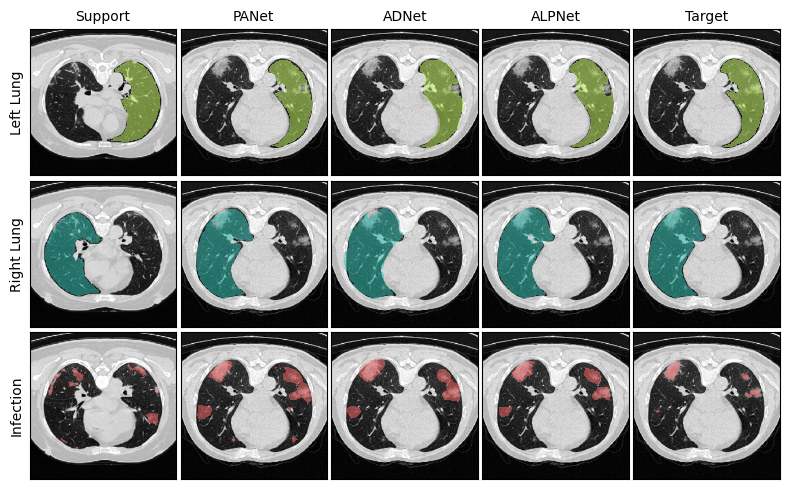




~~~~~~~~~~~~ Query ID: coronacases_003 ~~~~~~~~~~~~


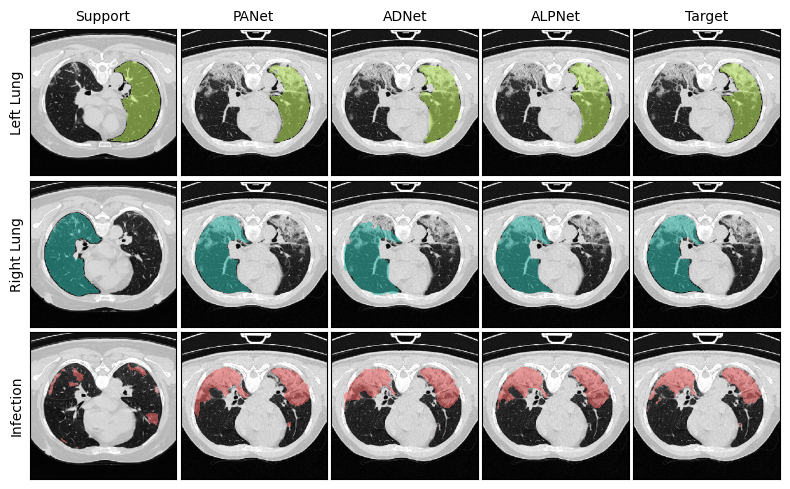




~~~~~~~~~~~~ Query ID: coronacases_004 ~~~~~~~~~~~~


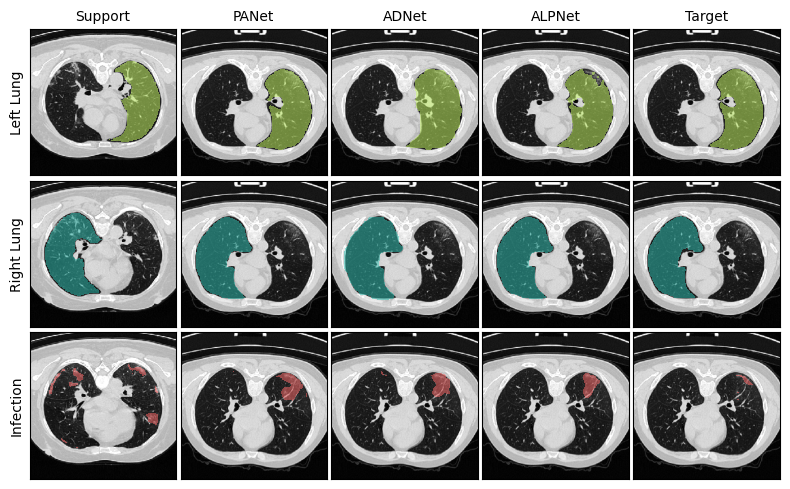




~~~~~~~~~~~~ Query ID: coronacases_005 ~~~~~~~~~~~~


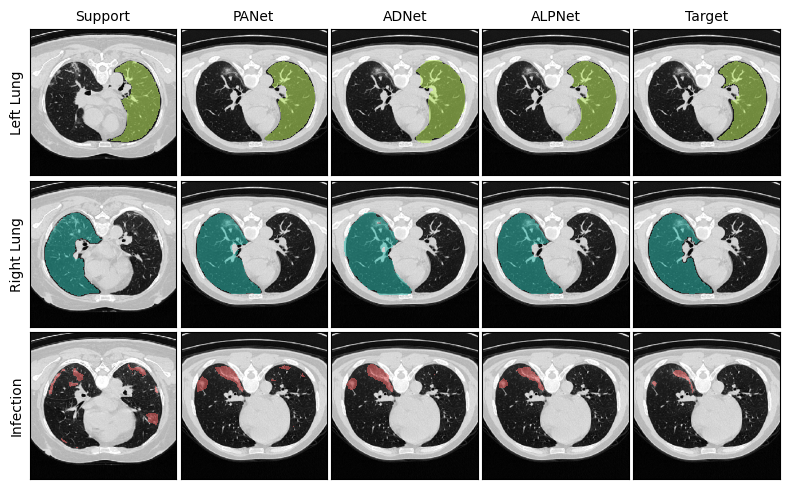

In [35]:
# Customise color map

color_dict = {
    1: {'color': [204, 255, 102], 'name': 'Left Lung'},
    2: {'color': [46, 196, 182], 'name': 'Right Lung'},
    3: {'color': [255, 102, 102], 'name': 'Infection'},
}
cmaplist = [list(np.array(color_dict[i]['color']) / 255.) for i in range(1, n_labels+1)]
custom_cmap = ListedColormap(cmaplist)

class_labels = ["Left Lung", "Right Lung", "Infection"]


# Display the results
for n, query_id in enumerate(test_sampler.query_ids):

    print(f"~~~~~~~~~~~~ Query ID: {query_id} ~~~~~~~~~~~~")
    fig, ax = plt.subplots(n_labels, 5, figsize=(8, 5))

    for l, label_name in enumerate(class_labels):
        # Support
        ax[l,0].imshow(supports[0,l,n], cmap='gray')
        ax[l,0].imshow(supports_mask[0,l,n], cmap=custom_cmap, vmin=1, vmax=n_labels, alpha=0.5)
        ax[l,0].set_ylabel(label_name, rotation=90, fontsize=10)
        ax[l,0].tick_params(axis='both', which='both', length=0, labelbottom=False, labelleft=False)

        # PANet Prediction
        ax[l,1].imshow(targets[0,l,n], cmap='gray')
        ax[l,1].imshow(predictions[0,l,n], cmap=custom_cmap, vmin=1, vmax=n_labels, alpha=0.5)
        ax[l,1].tick_params(axis='both', which='both', length=0, labelbottom=False, labelleft=False)

        # ADNet Prediction
        ax[l,2].imshow(targets[1,l,n], cmap='gray')
        ax[l,2].imshow(predictions[1,l,n], cmap=custom_cmap, vmin=1, vmax=n_labels, alpha=0.5)
        ax[l,2].tick_params(axis='both', which='both', length=0, labelbottom=False, labelleft=False)

        # ALPNet Prediction
        ax[l,3].imshow(targets[2,l,n], cmap='gray')
        ax[l,3].imshow(predictions[2,l,n], cmap=custom_cmap, vmin=1, vmax=n_labels, alpha=0.5)
        ax[l,3].tick_params(axis='both', which='both', length=0, labelbottom=False, labelleft=False)

        # Target
        ax[l,4].imshow(targets[0,l,n], cmap='gray')
        ax[l,4].imshow(targets_mask[0,l,n], cmap=custom_cmap, vmin=1, vmax=n_labels, alpha=0.5)
        ax[l,4].tick_params(axis='both', which='both', length=0, labelbottom=False, labelleft=False)

    # Titles
    ax[0,0].set_title("Support", fontsize=10)
    ax[0,1].set_title("PANet", fontsize=10)
    ax[0,2].set_title("ADNet", fontsize=10)
    ax[0,3].set_title("ALPNet", fontsize=10)
    ax[0,4].set_title("Target", fontsize=10)

    fig.tight_layout()
    fig.subplots_adjust(hspace=0.01, wspace=0.03)
    plt.show()
    print("\n\n")